In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support, average_precision_score

# Setup Device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ==========================================
# KONFIGURASI GLOBAL
# ==========================================
MODEL_NAME = "albert-base-v2"  # Menggunakan ALBERT
MAX_LEN = 96
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5

LABEL_COLS = ["admiration", "amusement", "gratitude", "love", "pride", "relief", "remorse"]

# ==========================================
# HELPER FUNCTIONS
# ==========================================

# 1. Fungsi Tokenisasi & Dataset
def create_dataloaders(df, tokenizer, max_len, batch_size, label_cols):
    # Split Train/Dev (80:20)
    train_df, dev_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    dev_df = dev_df.reset_index(drop=True)

    def _prepare(dataframe):
        texts = dataframe["text"].astype(str).tolist()
        labels = dataframe[label_cols].values.astype("float32")

        encodings = tokenizer(
            texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt"
        )
        dataset = TensorDataset(
            encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels)
        )
        return dataset

    train_dataset = _prepare(train_df)
    dev_dataset = _prepare(dev_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, dev_loader, dev_df

# 2. Fungsi Training
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)

        for ids, mask, labels in pbar:
            ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=ids, attention_mask=mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        print(f"Epoch {epoch} finished. Avg Loss: {total_loss/len(train_loader):.4f}")

# 3. Fungsi Prediksi
def get_predictions(model, loader, device):
    model.eval()
    all_probs = []
    all_true = []

    with torch.no_grad():
        for ids, mask, labels in loader:
            ids, mask = ids.to(device), mask.to(device)
            outputs = model(input_ids=ids, attention_mask=mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()

            all_probs.append(probs)
            all_true.append(labels.numpy())

    return np.concatenate(all_probs), np.concatenate(all_true)

# 4. Fungsi Hitung Metrik (Format PPT)
def calculate_metrics_ppt(probs, true_labels, label_cols):
    results = []
    for i, label in enumerate(label_cols):
        y_true = true_labels[:, i]
        y_score = probs[:, i]

        # Average Precision
        ap = average_precision_score(y_true, y_score)

        # Cari Best Threshold
        best_t = 0.5
        best_f1 = 0.0
        thresholds = np.arange(0.01, 1.0, 0.01)

        for t in thresholds:
            pred_t = (y_score >= t).astype(int)
            f1_t = f1_score(y_true, pred_t, zero_division=0)
            if f1_t > best_f1:
                best_f1 = f1_t
                best_t = t

        # Hitung Precision/Recall di Best Threshold
        final_preds = (y_score >= best_t).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, final_preds, average='binary', zero_division=0
        )

        results.append({
            "Label": label,
            "AP": round(ap, 3),
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1": round(f1, 3),
            "Threshold": round(best_t, 2)
        })

    return pd.DataFrame(results)

In [ ]:
# Download Tokenizer
print(f"Loading Tokenizer: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Loading Tokenizer: albert-base-v2...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
# 1. Load Data
file_1 = "/content/train_downsampled_4130.csv"
print(f"--- EXPERIMENT 1: {file_1} ---")
df1 = pd.read_csv(file_1)

# 2. Prepare DataLoader
train_loader1, dev_loader1, _ = create_dataloaders(df1, tokenizer, MAX_LEN, BATCH_SIZE, LABEL_COLS)

# 3. Init Model 1
model1 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(LABEL_COLS), problem_type="multi_label_classification"
).to(device)
optimizer1 = AdamW(model1.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# 4. Train Model 1
print("Training Model 1...")
train_model(model1, train_loader1, optimizer1, criterion, device, EPOCHS)

# 5. Evaluate Model 1
print("Evaluating Model 1...")
probs1, true1 = get_predictions(model1, dev_loader1, device)
results1 = calculate_metrics_ppt(probs1, true1, LABEL_COLS)

print("\nResult Model 1 (Downsampled/Augmented):")
print(results1)

--- EXPERIMENT 1: /content/train_downsampled_4130.csv ---


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Model 1...


Epoch 1/5:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 1 finished. Avg Loss: 0.2205


Epoch 2/5:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 2 finished. Avg Loss: 0.1852


Epoch 3/5:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 3 finished. Avg Loss: 0.1767


Epoch 4/5:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 4 finished. Avg Loss: 0.1707


Epoch 5/5:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 5 finished. Avg Loss: 0.1649
Evaluating Model 1...

Result Model 1 (Downsampled/Augmented):
        Label     AP  Precision  Recall     F1  Threshold
0  admiration  0.652      0.717   0.540  0.616       0.68
1   amusement  0.660      0.818   0.574  0.675       0.39
2   gratitude  0.761      0.943   0.651  0.770       0.30
3        love  0.676      0.791   0.534  0.638       0.23
4       pride  0.542      0.472   0.591  0.525       0.30
5      relief  0.430      0.314   0.749  0.442       0.23
6     remorse  0.484      0.387   0.880  0.538       0.19


In [ ]:
# 1. Load Data
file_2 = "/content/traindata.csv"
print(f"\n--- EXPERIMENT 2: {file_2} (Original Data) ---")
df2 = pd.read_csv(file_2)

# 2. Prepare DataLoader
# Data ini lebih besar, jadi proses training mungkin lebih lama
train_loader2, dev_loader2, _ = create_dataloaders(df2, tokenizer, MAX_LEN, BATCH_SIZE, LABEL_COLS)

# 3. Init Model 2 (Fresh Model)
model2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(LABEL_COLS), problem_type="multi_label_classification"
).to(device)
optimizer2 = AdamW(model2.parameters(), lr=LEARNING_RATE)
# Criterion sama (didefinisikan di atas)

# 4. Train Model 2
print("Training Model 2 (Original Data)...")
train_model(model2, train_loader2, optimizer2, criterion, device, EPOCHS)

# 5. Evaluate Model 2
print("Evaluating Model 2...")
probs2, true2 = get_predictions(model2, dev_loader2, device)
results2 = calculate_metrics_ppt(probs2, true2, LABEL_COLS)

print("\nResult Model 2 (Original):")
print(results2)


--- EXPERIMENT 2: /content/traindata.csv (Original Data) ---


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Model 2 (Original Data)...


Epoch 1/5:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1 finished. Avg Loss: 0.1075


Epoch 2/5:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 2 finished. Avg Loss: 0.0666


Epoch 3/5:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 3 finished. Avg Loss: 0.0573


Epoch 4/5:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 4 finished. Avg Loss: 0.0484


Epoch 5/5:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 5 finished. Avg Loss: 0.0420
Evaluating Model 2...

Result Model 2 (Original):
        Label     AP  Precision  Recall     F1  Threshold
0  admiration  0.849      0.770   0.812  0.791       0.17
1   amusement  0.874      0.823   0.900  0.860       0.41
2   gratitude  0.960      0.940   0.880  0.909       0.74
3        love  0.910      0.825   0.895  0.858       0.64
4       pride  0.429      0.625   0.556  0.588       0.12
5      relief  0.245      0.341   0.452  0.389       0.11
6     remorse  0.857      0.822   0.855  0.838       0.80


In [ ]:
# Menggabungkan hasil untuk perbandingan Side-by-Side
comparison_df = pd.merge(
    results1[["Label", "F1", "AP"]],
    results2[["Label", "F1", "AP"]],
    on="Label",
    suffixes=('_Augmented', '_Original')
)

# Hitung Delta (Selisih)
comparison_df["F1_Diff"] = comparison_df["F1_Augmented"] - comparison_df["F1_Original"]

print("\n=======================================================")
print(" COMPARISON REPORT: Augmented vs Original Data")
print("=======================================================")
print(comparison_df.to_string(index=False))

# Simpan hasil lengkap
results1.to_csv("results_augmented.csv", index=False)
results2.to_csv("results_original.csv", index=False)
comparison_df.to_csv("comparison_summary.csv", index=False)

print("\nAll results saved to CSV.")


 COMPARISON REPORT: Augmented vs Original Data
     Label  F1_Augmented  AP_Augmented  F1_Original  AP_Original  F1_Diff
admiration         0.616         0.652        0.791        0.849   -0.175
 amusement         0.675         0.660        0.860        0.874   -0.185
 gratitude         0.770         0.761        0.909        0.960   -0.139
      love         0.638         0.676        0.858        0.910   -0.220
     pride         0.525         0.542        0.588        0.429   -0.063
    relief         0.442         0.430        0.389        0.245    0.053
   remorse         0.538         0.484        0.838        0.857   -0.300

All results saved to CSV.


In [ ]:
# ==========================================
# TEST ON NEW DATA (dev.csv)
# ==========================================
print("\nLoading Test Data (dev.csv)...")
test_df = pd.read_csv("dev.csv")

# Pastikan label columns sama
LABEL_COLS = ["admiration", "amusement", "gratitude", "love", "pride", "relief", "remorse"]

# 1. Prepare Test DataLoader
def create_test_loader(df, tokenizer, max_len, batch_size, label_cols):
    texts = df["text"].astype(str).tolist()
    labels = df[label_cols].values.astype("float32")

    encodings = tokenizer(
        texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt"
    )
    dataset = TensorDataset(
        encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

test_loader = create_test_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE, LABEL_COLS)

# 2. Fungsi Evaluasi Final (Sama dengan format PPT)
def evaluate_test_set(model, loader, device, label_cols, model_name="Model"):
    print(f"\nEvaluating {model_name} on dev.csv...")
    model.eval()
    all_probs = []
    all_true = []

    with torch.no_grad():
        for ids, mask, labels in tqdm(loader, desc="Predicting"):
            ids, mask = ids.to(device), mask.to(device)
            outputs = model(input_ids=ids, attention_mask=mask)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()

            all_probs.append(probs)
            all_true.append(labels.numpy())

    y_probs = np.concatenate(all_probs)
    y_true = np.concatenate(all_true)

    results = []
    for i, label in enumerate(label_cols):
        true_l = y_true[:, i]
        prob_l = y_probs[:, i]

        # 1. AP (Average Precision)
        ap = average_precision_score(true_l, prob_l)

        # 2. Cari Best Threshold berdasarkan F1
        best_t, best_f1 = 0.5, 0.0
        thresholds = np.arange(0.01, 1.0, 0.01)
        for t in thresholds:
            pred_t = (prob_l >= t).astype(int)
            f1 = f1_score(true_l, pred_t, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t

        # 3. Precision, Recall, F1 di Best Threshold
        final_preds = (prob_l >= best_t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(
            true_l, final_preds, average='binary', zero_division=0
        )

        results.append({
            "Label": label,
            "AP": round(ap, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1": round(f1, 3),
            "Threshold": round(best_t, 2)
        })

    return pd.DataFrame(results)

# 3. Jalankan Evaluasi untuk Kedua Model
# (Pastikan model1 dan model2 sudah dilatih di cell sebelumnya)

# Hasil Model 1 (Augmented)
results_test_aug = evaluate_test_set(model1, test_loader, device, LABEL_COLS, "Model 1 (Augmented)")
print("\n=== HASIL TESTING: DATA AUGMENTED (Sesuai PPT) ===")
print(results_test_aug.to_string(index=False))

# Hasil Model 2 (Original)
results_test_orig = evaluate_test_set(model2, test_loader, device, LABEL_COLS, "Model 2 (Original)")
print("\n=== HASIL TESTING: DATA ORIGINAL (Sesuai PPT) ===")
print(results_test_orig.to_string(index=False))

# 4. Simpan Hasil ke CSV
results_test_aug.to_csv("test_results_augmented.csv", index=False)
results_test_orig.to_csv("test_results_original.csv", index=False)
print("\nHasil testing disimpan ke CSV.")


Loading Test Data (dev.csv)...

Evaluating Model 1 (Augmented) on dev.csv...


Predicting:   0%|          | 0/197 [00:00<?, ?it/s]


=== HASIL TESTING: DATA AUGMENTED (Sesuai PPT) ===
     Label    AP  Precision  Recall    F1  Threshold
admiration 0.841      0.766   0.838 0.800       0.52
 amusement 0.895      0.867   0.858 0.862       0.74
 gratitude 0.970      0.958   0.902 0.929       0.64
      love 0.863      0.788   0.885 0.834       0.40
     pride 0.440      0.750   0.400 0.522       0.89
    relief 0.248      0.462   0.333 0.387       0.23
   remorse 0.892      0.910   0.897 0.904       0.54

Evaluating Model 2 (Original) on dev.csv...


Predicting:   0%|          | 0/197 [00:00<?, ?it/s]


=== HASIL TESTING: DATA ORIGINAL (Sesuai PPT) ===
     Label    AP  Precision  Recall    F1  Threshold
admiration 0.871      0.802   0.814 0.808       0.27
 amusement 0.895      0.851   0.908 0.879       0.38
 gratitude 0.972      0.990   0.869 0.926       0.90
      love 0.872      0.799   0.917 0.854       0.51
     pride 0.504      0.889   0.533 0.667       0.24
    relief 0.388      0.833   0.278 0.417       0.62
   remorse 0.896      0.896   0.882 0.889       0.76

Hasil testing disimpan ke CSV.


Data hasil berhasil dimuat.


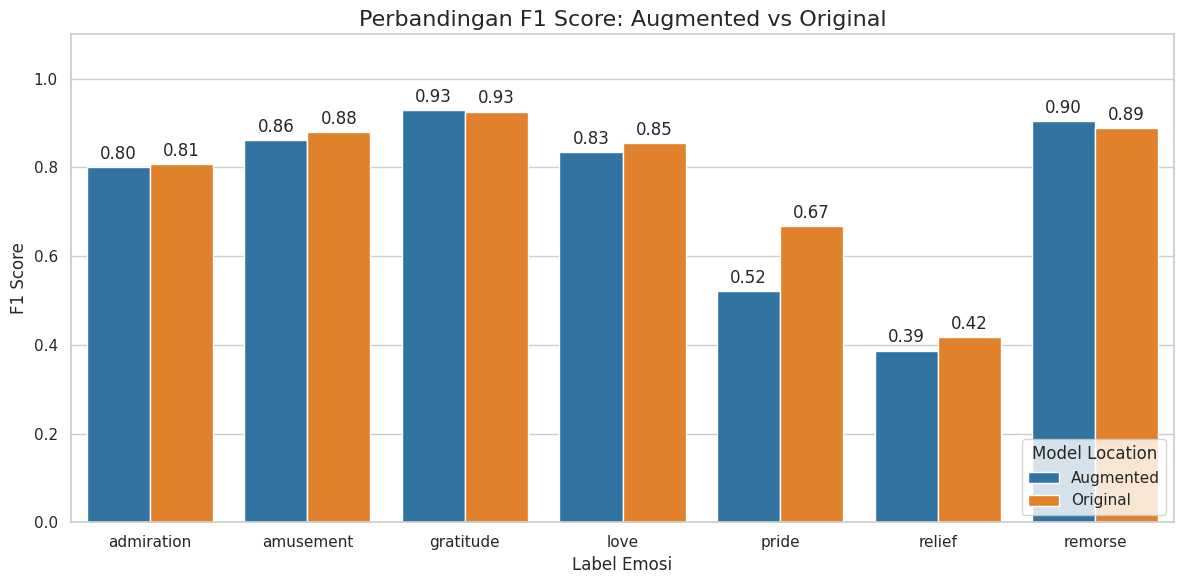

Grafik disimpan sebagai 'comparison_chart_F1.png'


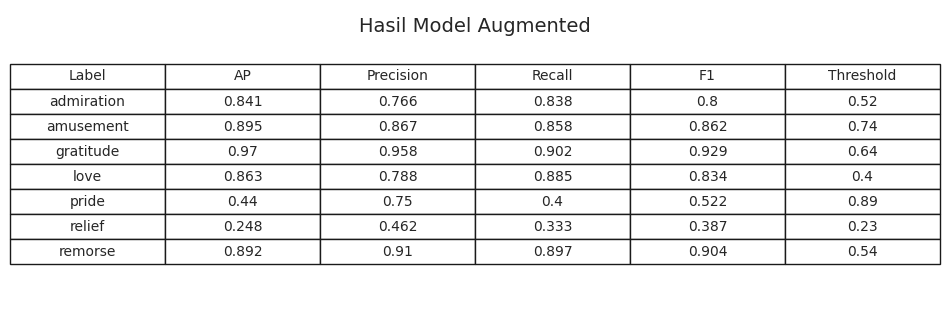

Tabel disimpan sebagai 'table_augmented.png'


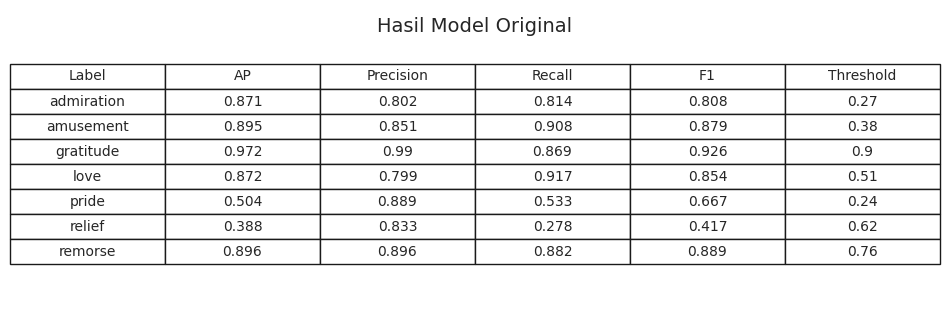

Tabel disimpan sebagai 'table_original.png'

Generating Confusion Matrices for Model Augmented...


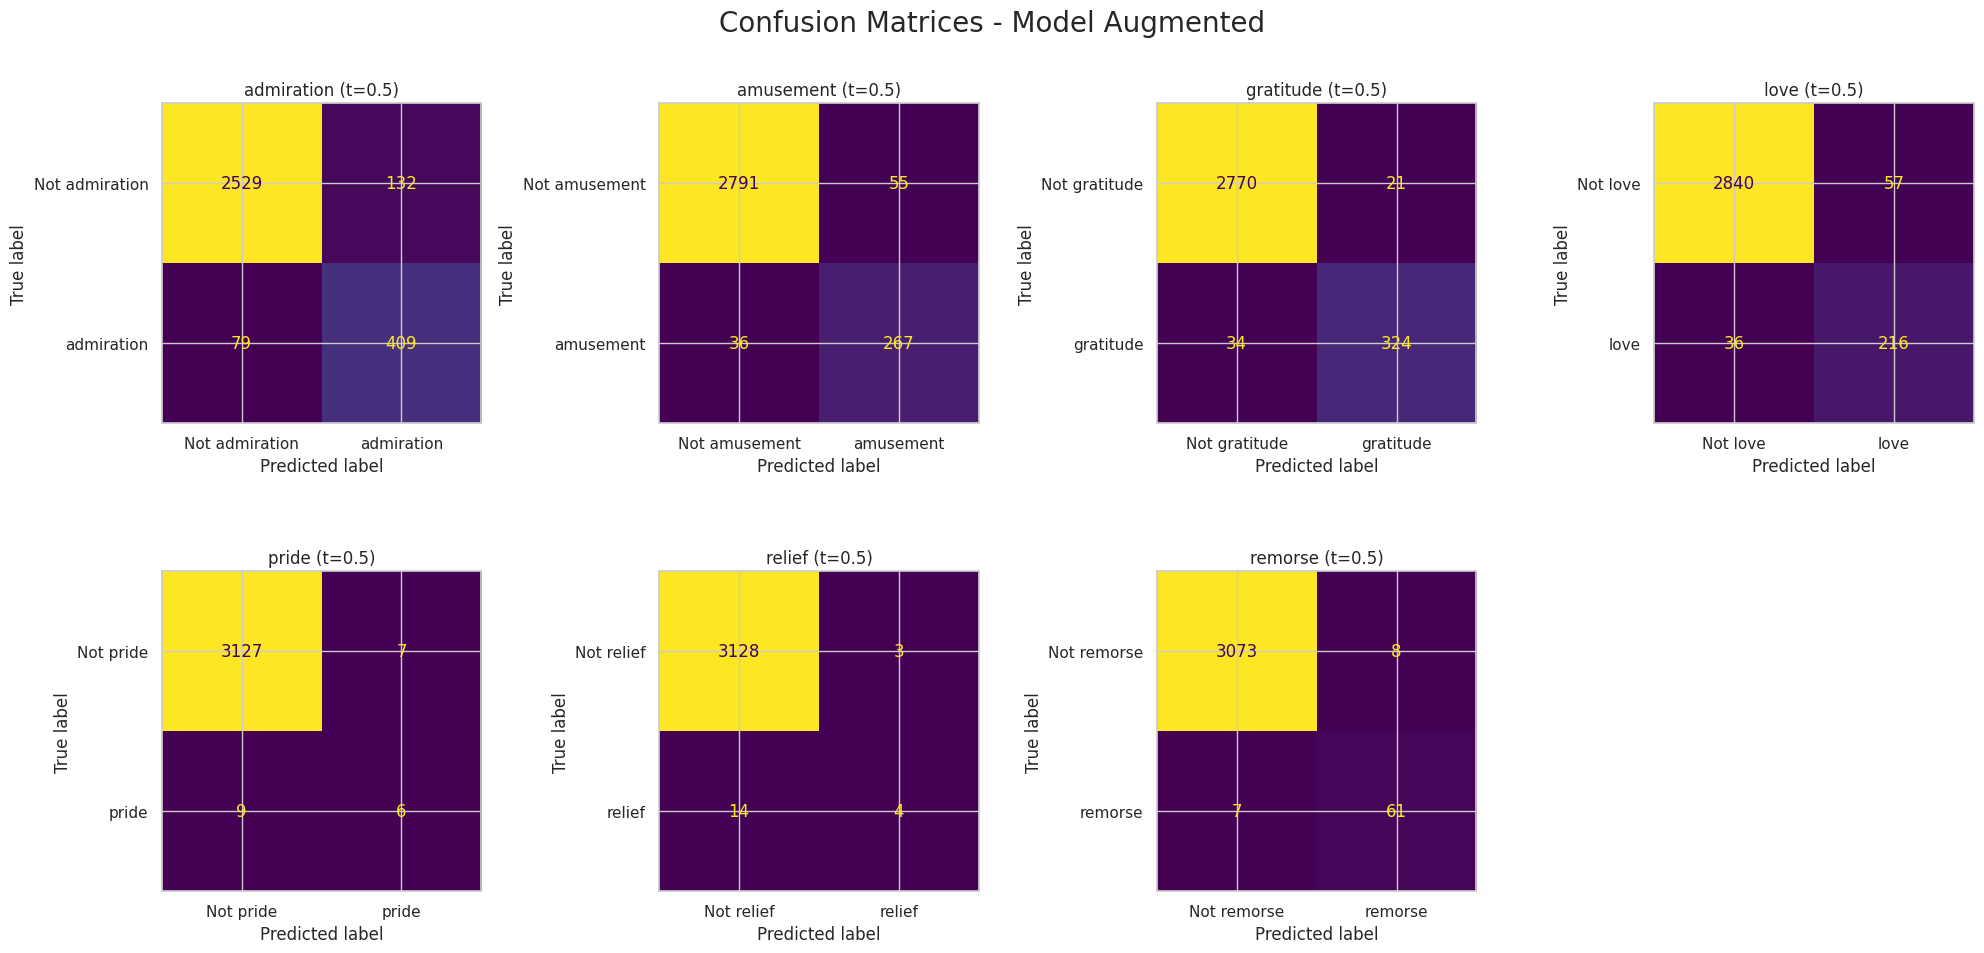


Generating Confusion Matrices for Model Original...


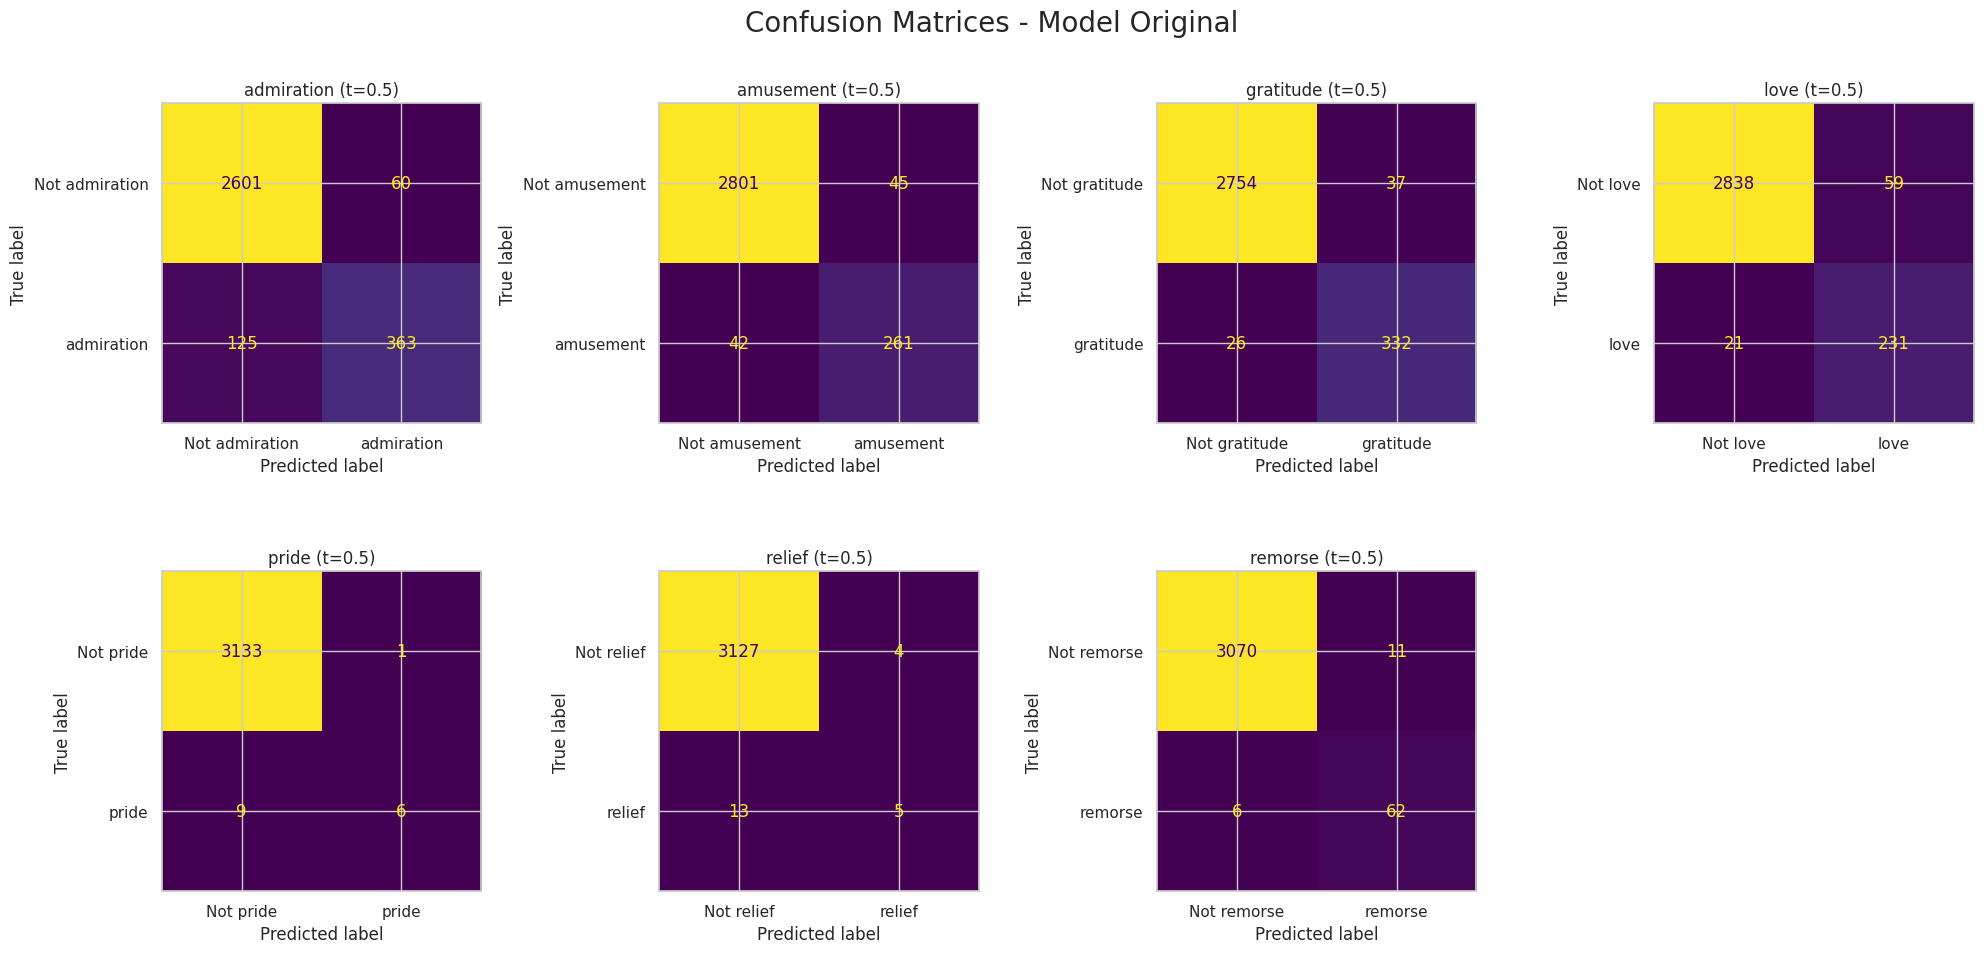

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ==========================================
# 1. LOAD DATA HASIL DARI CSV
# ==========================================
df_aug = None # Initialize df_aug
df_orig = None # Initialize df_orig
try:
    df_aug = pd.read_csv("test_results_augmented.csv")
    df_orig = pd.read_csv("test_results_original.csv")
    print("Data hasil berhasil dimuat.")
except FileNotFoundError:
    print("File CSV tidak ditemukan. Pastikan Anda sudah menjalankan cell evaluasi sebelumnya.")

# ==========================================
# 2. MEMBUAT GRAFIK PERBANDINGAN (BAR CHART)
# ==========================================
def plot_comparison(df1, df2, metric="F1"):
    # Gabungkan data
    df1["Model"] = "Augmented"
    df2["Model"] = "Original"
    df_combined = pd.concat([df1, df2])

    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")

    # Plot Bar Chart
    ax = sns.barplot(
        data=df_combined,
        x="Label",
        y=metric,
        hue="Model",
        palette=["#1f77b4", "#ff7f0e"] # Biru & Oranye
    )

    plt.title(f"Perbandingan {metric} Score: Augmented vs Original", fontsize=16)
    plt.ylim(0, 1.1)
    plt.ylabel(metric + " Score")
    plt.xlabel("Label Emosi")
    plt.legend(title="Model Location", loc='lower right')

    # Tampilkan angka di atas bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

    plt.tight_layout()
    plt.savefig(f"comparison_chart_{metric}.png", dpi=300)
    plt.show()
    print(f"Grafik disimpan sebagai 'comparison_chart_{metric}.png'")

# Jalankan Plotting
if df_aug is not None and df_orig is not None: # Add check for loaded dataframes
    plot_comparison(df_aug.copy(), df_orig.copy(), metric="F1")
else:
    print("Cannot plot comparison, dataframes were not loaded.")

# ==========================================
# 3. MENYIMPAN TABEL SEBAGAI GAMBAR
# ==========================================
def save_table_as_image(df, filename, title):
    fig, ax = plt.subplots(figsize=(10, 4)) # Ukuran disesuaikan
    ax.axis('tight')
    ax.axis('off')

    # Membuat tabel
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5) # Scaling ukuran sel

    plt.title(title, fontsize=14, y=0.9)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"Tabel disimpan sebagai '{filename}'")

# Simpan kedua tabel
if df_aug is not None: # Add check for loaded dataframe
    save_table_as_image(df_aug, "table_augmented.png", "Hasil Model Augmented")
else:
    print("Cannot save augmented table, dataframe was not loaded.")
if df_orig is not None: # Add check for loaded dataframe
    save_table_as_image(df_orig, "table_original.png", "Hasil Model Original")
else:
    print("Cannot save original table, dataframe was not loaded.")

# ==========================================
# 4. VISUALISASI CONFUSION MATRIX
# ==========================================
# Fungsi ini membutuhkan model dan loader yang masih aktif di memori
def plot_confusion_matrices(model, loader, device, label_cols, model_name, cmap='viridis'): # Added cmap argument with default
    print(f"\nGenerating Confusion Matrices for {model_name}...")
    model.eval()
    all_preds = []
    all_true = []

    # Ambil prediksi (bisa memakan waktu)
    with torch.no_grad():
        for ids, mask, labels in loader:
            ids, mask = ids.to(device), mask.to(device)
            outputs = model(input_ids=ids, attention_mask=mask) # Corrected typo here
            probs = torch.sigmoid(outputs.logits)
            all_preds.append(probs.cpu().numpy())
            all_true.append(labels.numpy())

    y_probs = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)

    # Siapkan Canvas Grid (2 baris x 4 kolom)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, label in enumerate(label_cols):
        # Ambil threshold terbaik dari dataframe hasil (jika ada), atau default 0.5
        # Di sini kita pakai 0.5 untuk penyederhanaan visualisasi umum
        threshold = 0.5

        y_p = (y_probs[:, i] >= threshold).astype(int)
        y_t = y_true[:, i]

        cm = confusion_matrix(y_t, y_p)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Not {label}", label])

        disp.plot(ax=axes[i], cmap=cmap, values_format='d', colorbar=False) # Used the cmap argument here
        axes[i].set_title(f"{label} (t={threshold})")

    # Hapus subplot kosong jika ada (karena 7 label, grid ada 8 slot)
    if len(label_cols) < 8:
        fig.delaxes(axes[7])

    plt.suptitle(f"Confusion Matrices - {model_name}", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{model_name.replace(' ', '_')}.png")
    plt.show()

# Jalankan Visualisasi CM (Pastikan model1/model2 dan test_loader ada di memori)
# Jika memory error, jalankan satu per satu
if 'model1' in globals() and 'test_loader' in globals():
    plot_confusion_matrices(model1, test_loader, device, LABEL_COLS, "Model Augmented", cmap='viridis') # Passing cmap

if 'model2' in globals() and 'test_loader' in globals():
    plot_confusion_matrices(model2, test_loader, device, LABEL_COLS, "Model Original", cmap='viridis') # Passing cmap